In [25]:
#Define Reset Graph function 
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [14]:
#import dependencies and paths

import matplotlib.pyplot as plt
import os
import sys
import tarfile
from six.moves import urllib
import numpy as np
import matplotlib.image as mpimg

Animals_PATH = os.path.join("datasets", "picdb")
animals_root_path = os.path.join(Animals_PATH, "Animals")
animal_classes = sorted([dirname for dirname in os.listdir(animals_root_path)
                  if os.path.isdir(os.path.join(animals_root_path, dirname))])
animal_classes


In [16]:
# define image paths for dictionary/class splitting

from collections import defaultdict

image_paths = defaultdict(list)

for animal_class in animal_classes:
    image_dir = os.path.join(animals_root_path, animal_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[animal_class].append(os.path.join(image_dir, filepath))

In [17]:
# sort the paths
for paths in image_paths.values():
    paths.sort()

In [27]:
# declare channels/resolution
channels = 3
width = 299
height = 299
n_examples_per_class = 2


Class: coyote


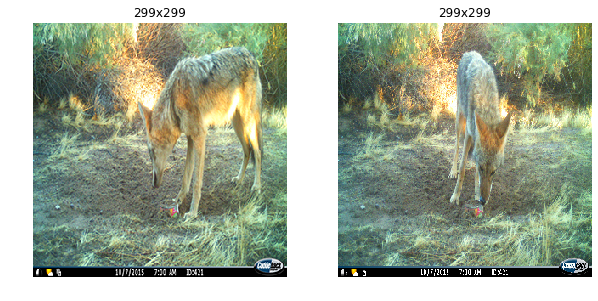

Class: desert tortoise


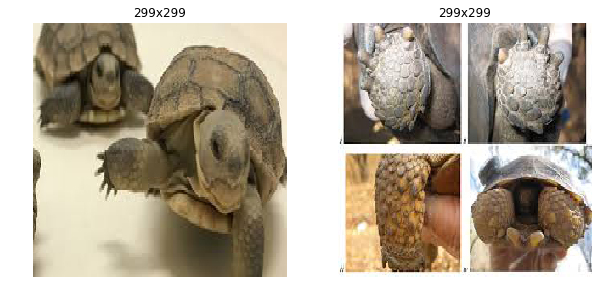

Class: grey fox


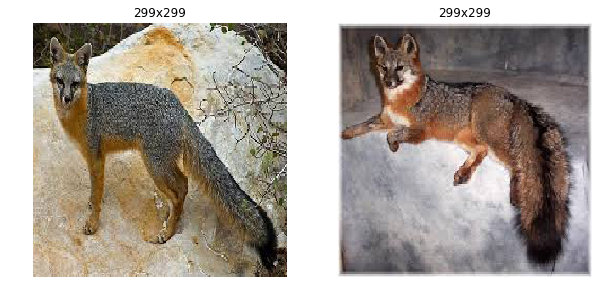

Class: jack rabbit


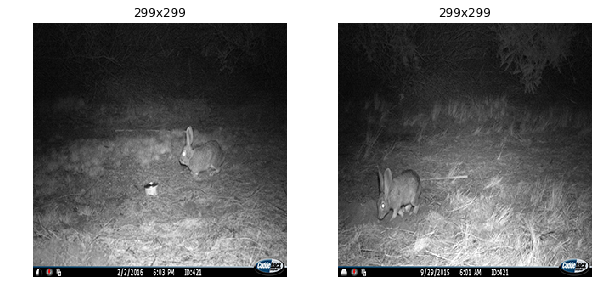

Class: kit fox


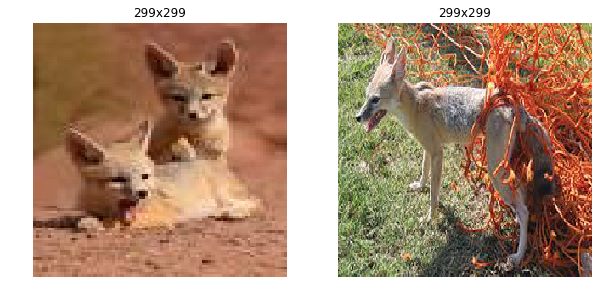

In [20]:
# test print out images/classes

for animal_class in animal_classes:
    print("Class:", animal_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[animal_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

In [23]:
#Define tensorflow image resize function

def prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])   # 3 = number of channels

    # Let's crop the image using a random bounding box of the size we computed
    image = tf.random_crop(image, box_size)

    # Let's also flip the image horizontally with 50% probability:
    image = tf.image.random_flip_left_right(image)

    # The resize_bilinear function requires a 4D tensor (a batch of images)
    # so we need to expand the number of dimensions first:
    image_batch = tf.expand_dims(image, 0)

    # Finally, let's resize the image to the target dimensions. Note that this function
    # returns a float32 tensor.
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    image = image_batch[0] / 255  # back to a single image, and scale the colors from 0.0 to 1.0
    return image

In [28]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim
import tensorflow as tf

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

In [29]:
#inspect inception model's layers
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

In [30]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/Conv2D:0' shape=(?, 1, 1, 1001) dtype=float32>

In [31]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [32]:
end_points

{'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=float32>,
 'Mixed_5b': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5b/concat:0' shape=(?, 35, 35, 256) dtype=float32>,
 'Mixed_5c': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5c/concat:0' shape=(?,

In [33]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [34]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

In [35]:
n_outputs = len(animal_classes)

with tf.name_scope("new_output_layer"):
    animal_logits = tf.layers.dense(prelogits, n_outputs, name="animal_logits")
    Y_proba = tf.nn.softmax(animal_logits, name="Y_proba")

In [36]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=animal_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    animal_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="animal_logits")
    training_op = optimizer.minimize(loss, var_list=animal_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(animal_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [37]:
[v.name for v in animal_vars]

['animal_logits/kernel:0', 'animal_logits/bias:0']

In [38]:
animal_class_ids = {animal_class: index for index, animal_class in enumerate(animal_classes)}
animal_class_ids

{'coyote': 0,
 'desert tortoise': 1,
 'grey fox': 2,
 'jack rabbit': 3,
 'kit fox': 4}

In [39]:
animal_paths_and_classes = []
for animal_class, paths in image_paths.items():
    for path in paths:
        animal_paths_and_classes.append((path, animal_class_ids[animal_class]))

In [40]:
test_ratio = 0.2
train_size = int(len(animal_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(animal_paths_and_classes)

animal_paths_and_classes_train = animal_paths_and_classes[:train_size]
animal_paths_and_classes_test = animal_paths_and_classes[train_size:]

In [41]:
animal_paths_and_classes_train[:3]

[('datasets\\picdb\\Animals\\coyote\\coyote (199).jpg', 0),
 ('datasets\\picdb\\Animals\\grey fox\\images (86).jpg', 2),
 ('datasets\\picdb\\Animals\\kit fox\\kit fox (29).jpg', 4)]

In [44]:
from random import sample
from scipy.misc import imresize

def prepare_batch(animal_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(animal_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [45]:
X_batch, y_batch = prepare_batch(animal_paths_and_classes_train, batch_size=4)

c:\users\tpython\anaconda3\envs\tfgpu15\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [46]:
X_batch.shape

(4, 299, 299, 3)

In [47]:

X_batch.dtype

dtype('float32')

In [48]:
y_batch.shape

(4,)

In [49]:
y_batch.dtype

dtype('int32')

In [50]:
X_test, y_test = prepare_batch(animal_paths_and_classes_test, batch_size=len(animal_paths_and_classes_test))

c:\users\tpython\anaconda3\envs\tfgpu15\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [51]:
X_test.shape

(121, 299, 299, 3)

In [54]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(animal_paths_and_classes_train) // batch_size
INCEPTION_PATH = os.path.join("datasets", "inception")

INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")



with tf.device("/gpu:0"):

    with tf.Session() as sess:
        init.run()
        inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

        for epoch in range(n_epochs):
            print("Epoch", epoch, end="")
            for iteration in range(n_iterations_per_epoch):
                print(".", end="")
                X_batch, y_batch = prepare_batch(animal_paths_and_classes_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            print("  Train accuracy:", acc_train)

            save_path = saver.save(sess, "./my_animals_model")

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt
Epoch 0.

c:\users\tpython\anaconda3\envs\tfgpu15\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


...........  Train accuracy: 0.625
Epoch 1............  Train accuracy: 0.85
Epoch 2............  Train accuracy: 0.9
Epoch 3............  Train accuracy: 0.975
Epoch 4............  Train accuracy: 0.9
Epoch 5............  Train accuracy: 0.9
Epoch 6............  Train accuracy: 0.875
Epoch 7............  Train accuracy: 0.95
Epoch 8............  Train accuracy: 0.925
Epoch 9............  Train accuracy: 0.875


In [55]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.device("/gpu:0"):

    with tf.Session() as sess:
        saver.restore(sess, "./my_animals_model")

        print("Computing final accuracy on the test set (this will take a while)...")
        acc_test = np.mean([
            accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
            for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
        print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_animals_model
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.92564106


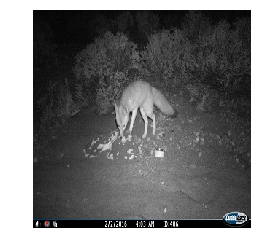

In [59]:
test_image = mpimg.imread(os.path.join("pic_db","kit_fox","test2.jpg"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [60]:
np.expand_dims(test_image, axis=0)

array([[[[ 7,  7,  7],
         [ 5,  5,  5],
         [ 7,  7,  7],
         ...,
         [ 9,  9,  9],
         [ 8,  8,  8],
         [ 8,  8,  8]],

        [[ 7,  7,  7],
         [ 5,  5,  5],
         [ 5,  5,  5],
         ...,
         [ 8,  8,  8],
         [ 9,  9,  9],
         [10, 10, 10]],

        [[ 8,  8,  8],
         [ 8,  8,  8],
         [ 6,  6,  6],
         ...,
         [ 5,  5,  5],
         [ 7,  7,  7],
         [ 9,  9,  9]],

        ...,

        [[ 2,  2,  2],
         [ 0,  0,  0],
         [ 2,  2,  2],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 2,  2,  2],
         [ 1,  1,  1],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]]], dtype=uint8)

In [61]:
X_test = test_image.reshape(-1, height, width, channels)

In [63]:
with tf.device("/gpu:0"):
    # Setup operations


    with tf.Session() as sess:
        predictions = end_points["Predictions"]
        saver.restore(sess, "./my_animals_model")
        predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_animals_model


In [64]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

917

In [67]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)
    
class_names = ["background"] + load_class_names()
class_names[most_likely_class_index]

'web site, website, internet site, site'